# DataScribe: AI-Powered Schema Explorer

## Disclaimer
DO NOT use this on production data, it is untested and has no safety rails as to what the agent will do, it is possible for it to attempt to do INSERT, UPDATE and DELETE.

If you are planning on testing it on your own data, ensure you have setup a READONLY user.

You have been warned. :)

## 🚀 **What’s the Idea?**

This project focuses on exploring an **AI Agent system** designed to assist users in exploring, querying, and analysing relational databases.

The system looks to simplify database tasks by enabling intuitive operations, such as:

- **Schema Discovery and Inference**: Helping users uncover and understand the structure of databases.
- **Complex Query Execution**: Supporting intricate operations to extract insights effectively.

The system has a **stateful Supervisor Agent** that oversees and coordinates multiple specialised, stateless sub-agents. These sub-agents will focus on tasks like:

- **Supervisor**
- **Planning**
- **Discovery**
- **Inference**

---

## 🛠 **Tech Stack**

Here’s the stack we’re leveraging to bring this project to life:

- **Python**: The backbone of our agent system, powering logic and workflows.
- **LangChain/LangGraph**: Managing interactions and workflows for AI components.
- **SQLite**: The primary relational database for development and testing.
- **GraphDB**: NetworkX, Visualising relationships within the database.

---

## 🧩 **Use Case**

This project is to explore interacting with relational databases for accessibility, especially for non-expert users.

Our **AI agents** look to simplify:

- **Database Discovery**: Exploring and understanding schemas and relationships.
- **Pattern Inference**: Querying and analysing data.

---

## 🎯 **What’s the Goal?**

To create a robust and versatile **AI agent system** that:

- **Simplifies database tasks** for non-expert users.
- Handles operations like discovery, inference, and insight generation autonomously.
- Bridges the gap between technical data management and intuitive user interaction.

Here is our State Graph for how our agent fleet processes input from a user.

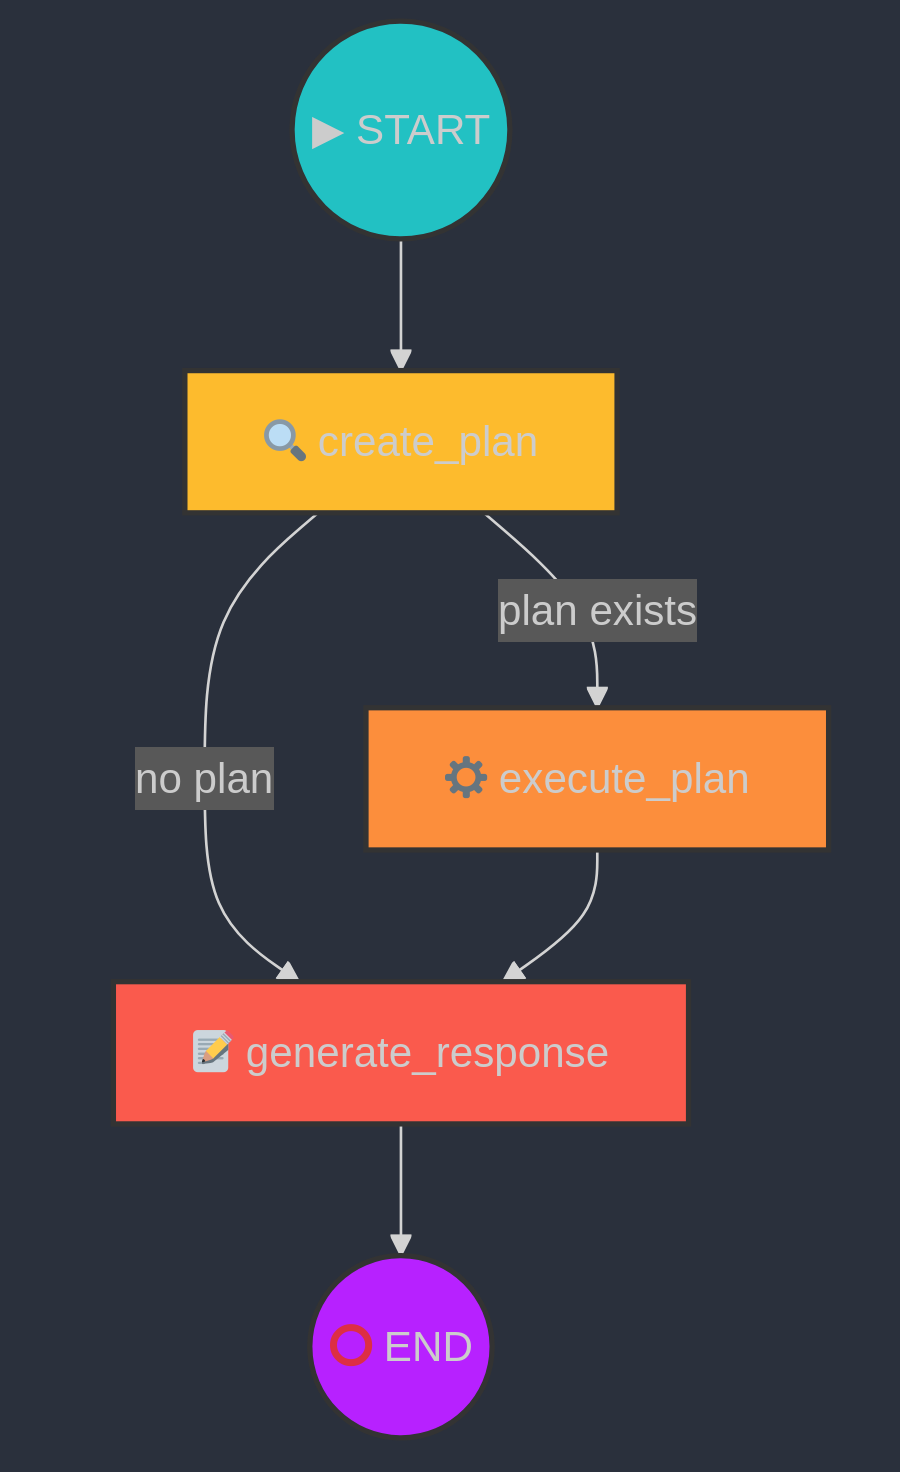

Here is how we have architected the application.

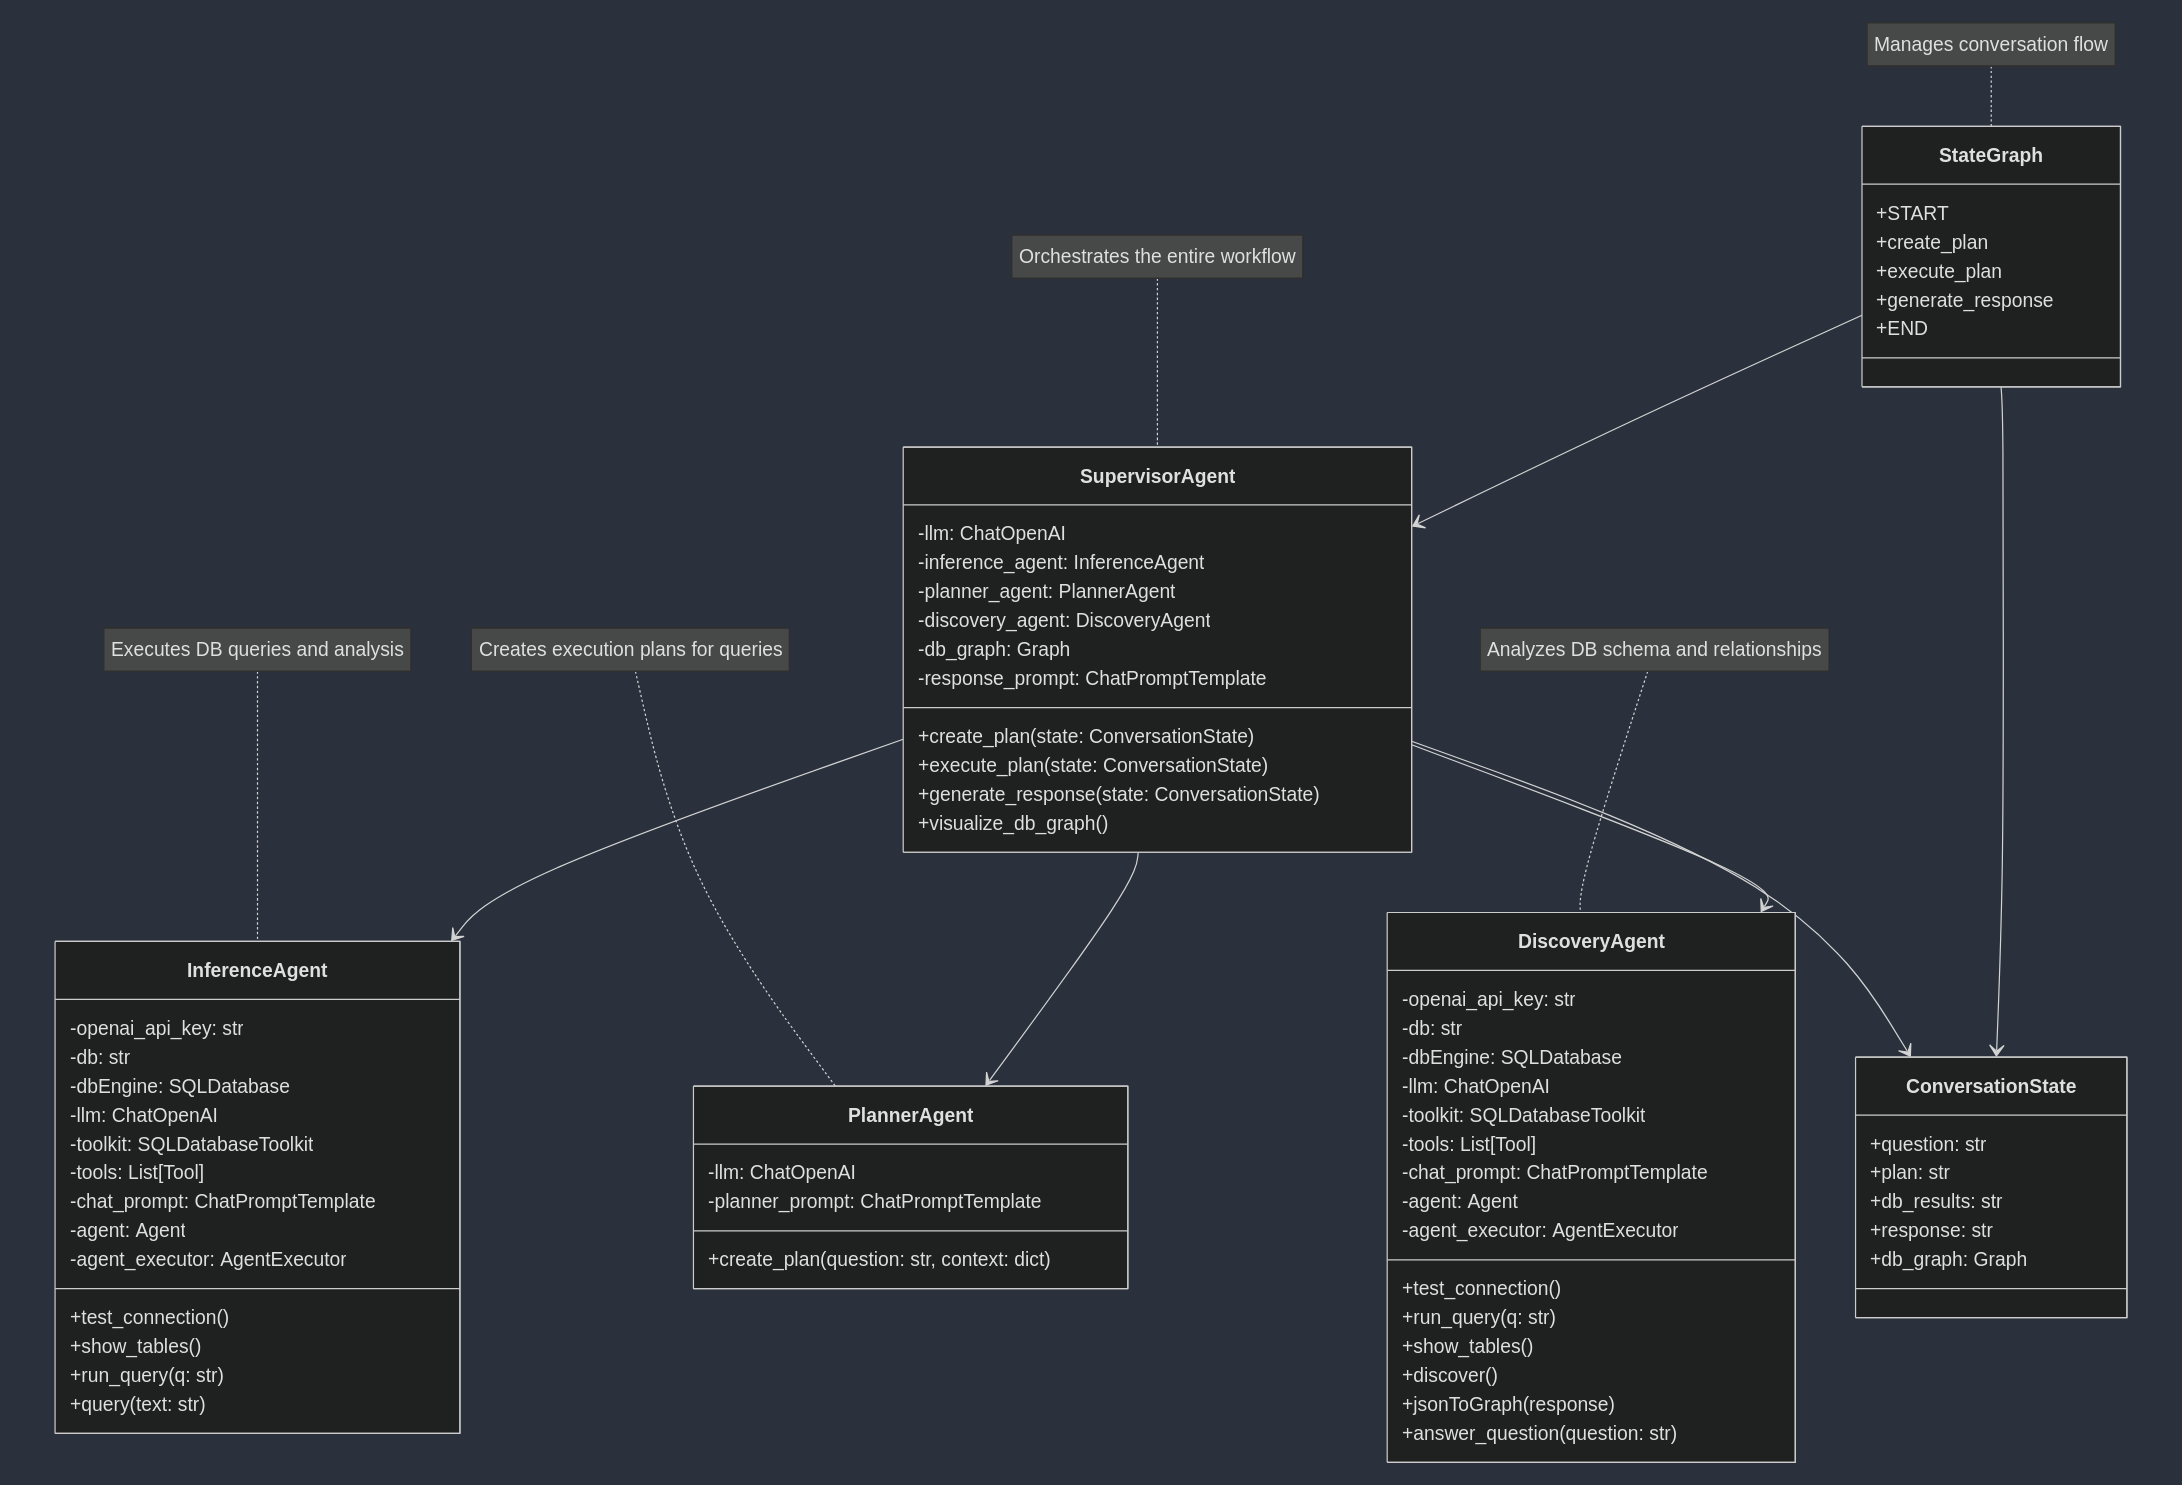

# Packages needed to run the tutorial

In [ ]:
!pip install langgraph langchain langchain-openai langchain_community python-dotenv networkx matplotlib pydot networkx python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36


# Import required libraries and export environment variables

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from typing_extensions import NotRequired
from typing import Annotated, TypedDict
import networkx as nx
import logging
import os
from langgraph.graph import StateGraph, START, END

import json
import matplotlib.pyplot as plt
import networkx as nx
from dotenv import load_dotenv
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.tools import Tool
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
from networkx.drawing.nx_pydot import graphviz_layout


In [ ]:
os.environ["OPENAI_API_KEY"] = "PUT YOUR KEY HERE"
os.environ["DATABASE"] = "sqlite:///data/chinook.db"

# Discovery Agent

DiscoverAgent looks at a database, identifies tables, columns and foreign keys, then returns a Graph object of the relations.

The intent for this agent, though we didn't get a chance to finish it, was to create a graph of the table relationships which would then be used by the other agents.

In [ ]:

class DiscoveryAgent:
    def __init__(self):
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        self.db = os.getenv("DATABASE")

        if not all([self.openai_api_key, self.db]):
            raise ValueError("Missing required environment variables: OPENAI_API_KEY, DATABASE")

        # Initialize DB
        self.dbEngine = SQLDatabase.from_uri(f"{self.db}")

        # Initialize LLM
        self.llm = ChatOpenAI(temperature=0, model_name="gpt-4")

        # Create toolkit and tools
        self.toolkit = SQLDatabaseToolkit(db=self.dbEngine, llm=self.llm)
        self.tools = self.toolkit.get_tools()

        # Add results formatting tool and question answering tool
        self.tools.extend([
            Tool(
                name="VISUALISE_SCHEMA",
                func=self.discover,
                description="Creates a visual graph representation of the database schema showing tables, columns, and their relationships."
            )
        ])

        # Create prompt
        self.chat_prompt = self.create_chat_prompt()

        # Create agent and executor
        self.agent = create_openai_functions_agent(
            llm=self.llm,
            prompt=self.chat_prompt,
            tools=self.tools
        )

        self.agent_executor = AgentExecutor.from_agent_and_tools(
            agent=self.agent,
            tools=self.tools,
            verbose=True,
            handle_parsing_errors=True,
            max_iterations=15
        )

    def test_connection(self):
        self.show_tables()

    def run_query(self, q):
        return self.dbEngine.run(q)

    def show_tables(self):
        q = '''
            SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table","view");
            '''
        return self.run_query(q)

    def create_chat_prompt(self):
        system_message = SystemMessagePromptTemplate.from_template(
            """
            You are an AI assistant for querying a SQLLite database named {db_name}.
            Your responses should be formatted as json only.
            Always strive for clarity, terseness and conciseness in your responses.
            Return a json array with all the tables, using the example below:

            Example output:
            ```json
            [
                {{
                    tableName: [NAME OF TABLE RETURNED],
                    columns: [
                        {{
                            "columnName": [COLUMN 1 NAME],
                            "columnType": [COLUMN 1 TYPE],
                            "isOptional": [true OR false],
                            "foreignKeyReference": {{
                                "table": [REFERENCE TABLE NAME],
                                "column": [REFERENCE COLUMN NAME]
                            }}
                        }},
                        {{
                            "columnName": [COLUMN 2 NAME],
                            "columnType": [COLUMN 2 TYPE],
                            "isOptional": [true OR false],
                            "foreignKeyReference": {{
                                "table": [REFERENCE TABLE NAME],
                                "column": [REFERENCE COLUMN NAME]
                            }}
                        }}
                    ]
                }}
            ]
            ```

            ## mandatory
            only output json
            do not put any extra commentary
            """
        )

        human_message = HumanMessagePromptTemplate.from_template("{input}\n\n{agent_scratchpad}")
        return ChatPromptTemplate.from_messages([system_message, human_message])


    def discover(self):
        """
        Creates a visual representation of the database schema.
        Ignores any additional arguments passed by the tool system.
        """
        prompt = "For all tables in this database, show the table name, column name, column type, if its optional. Also show Foreign key references to other columns. Do not show examples. Output only as json."
        response = self.agent_executor.invoke({"input": prompt, "db_name": self.db})
        self.jsonToGraph(response)
        return "Database schema visualization has been generated."

    def jsonToGraph(self, response):
        output_ = response['output']
        self.parseJson(output_)

    def parseJson(self, output_):
        j = output_[output_.find('\n') + 1:output_.rfind('\n')]
        data = json.loads(j)

        G = nx.Graph()
        nodeIds = 0
        columnIds = len(data) + 1
        labeldict = {}
        color_map = []
        canonicalColumns = dict()
        for table in data:
            nodeIds += 1
            G.add_node(nodeIds)
            G.nodes[nodeIds]['tableName'] = table["tableName"]
            labeldict[nodeIds] = table["tableName"]
            color_map.append('red')
            for column in table["columns"]:
                columnIds += 1
                G.add_node(columnIds)
                G.nodes[columnIds]['columnName'] = column["columnName"]
                G.nodes[columnIds]['columnType'] = column["columnType"]
                G.nodes[columnIds]['isOptional'] = column["isOptional"]
                labeldict[columnIds] = column["columnName"]
                color_map.append('green')
                canonicalColumns[table["tableName"] + column["columnName"]] = columnIds
                G.add_edge(nodeIds, columnIds)

        for table in data:
            for column in table["columns"]:
                if column["foreignKeyReference"] is not None:
                    this_column = table["tableName"] + column["columnName"]
                    reference_column_ = column["foreignKeyReference"]["table"] + column["foreignKeyReference"]["column"]
                    G.add_edge(canonicalColumns[this_column], canonicalColumns[reference_column_])

        pos = graphviz_layout(G, prog='neato')
        plt.rcParams['figure.figsize'] = [20, 20]
        nx.draw(G, pos, labels=labeldict, node_color=color_map, with_labels=True)
        plt.show()

        return G


# Discovery test

This enables you to test the DiscoverAgent in isolation. This will do discovery on the sample database, then render the tables, columns and their relations.

This method takes some time (2-3 minutes), using OpenAI. Other llms untested.

Verbose is True for the agent so you can see its workings.



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks
Invoking: `sql_db_schema` with `{'table_names': 'albums, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracks'}`



CREATE TABLE albums (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES artists ("ArtistId")
)

/*
3 rows from albums table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE artists (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from artists table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE customers (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NUL

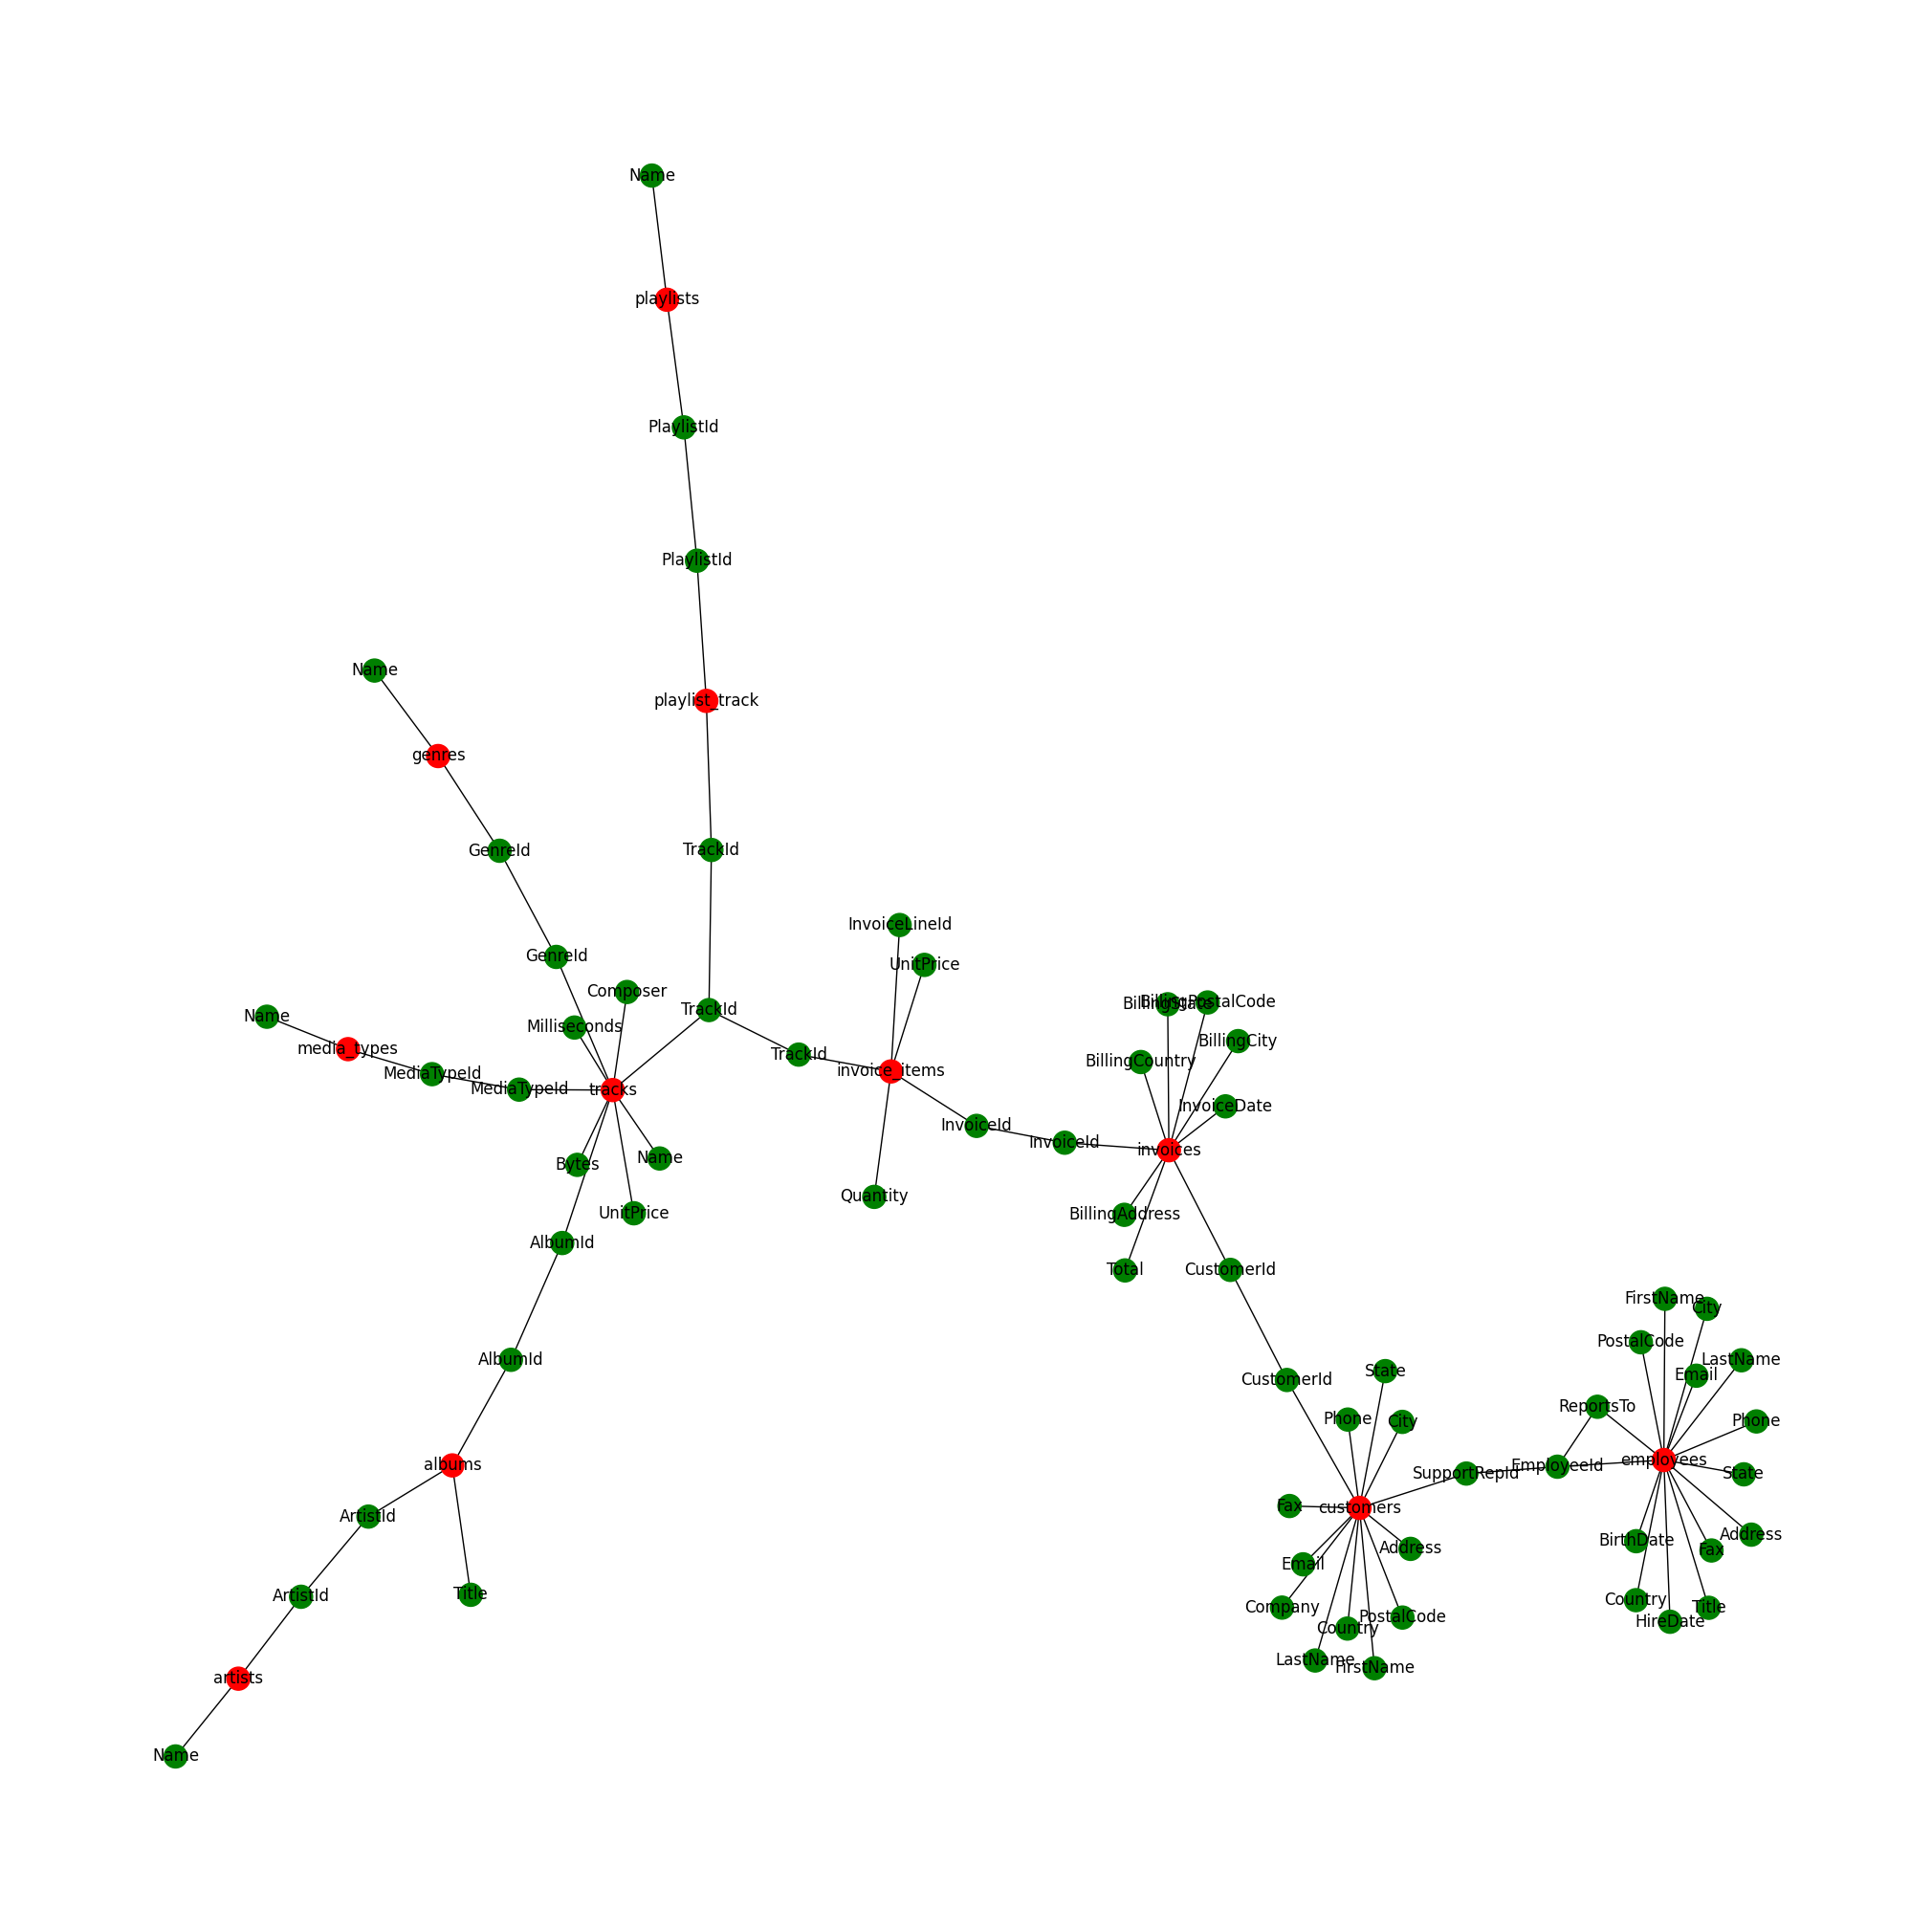

In [ ]:
agent = DiscoveryAgent()
G = agent.discover()




# Interference Agent

This defines the inference agent. This agenst's role is to answer any database analysis questions, "how many employees do we have", "what is the total value of all the invoices for the year" etc.

In [ ]:
class InferenceAgent:
    def __init__(self):
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        self.db = os.getenv("DATABASE")

        if not all([self.openai_api_key, self.db]):
            raise ValueError("Missing required environment variables: OPENAI_API_KEY, DATABASE")

        self.dbEngine = SQLDatabase.from_uri(f"{self.db}")
        self.llm = ChatOpenAI(temperature=0)
        self.toolkit = SQLDatabaseToolkit(db=self.dbEngine, llm=self.llm)
        self.tools = self.toolkit.get_tools()
        self.chat_prompt = self.create_chat_prompt()

        self.agent = create_openai_functions_agent(
            llm=self.llm,
            prompt=self.chat_prompt,
            tools=self.tools
        )

        self.agent_executor = AgentExecutor.from_agent_and_tools(
            agent=self.agent,
            tools=self.tools,
            verbose=False,
            handle_parsing_errors=True,
            max_iterations=15
        )

        self.test_connection()

    def test_connection(self):
        try:
            self.show_tables()
            print("Database connection successful")
        except Exception as e:
            print(f"Database connection failed: {str(e)}")
            raise

    def show_tables(self) -> str:
        q = '''
            SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table","view");
            '''
        return self.run_query(q)

    def run_query(self, q: str) -> str:
        try:
            return self.dbEngine.run(q)
        except Exception as e:
            print(f"Query execution failed: {str(e)}")
            return f"Error executing query: {str(e)}"

    def create_chat_prompt(self) -> ChatPromptTemplate:
        system_message = SystemMessagePromptTemplate.from_template(
            """You are a database inference expert for a SQLite database named {db_name}.
            Your job is to answer questions by querying the database and providing clear, accurate results.

            Rules:
            1. ONLY execute queries that retrieve data
            2. DO NOT provide analysis or recommendations
            3. Format responses as:
               Query Executed: [the SQL query used]
               Results: [the query results]
               Summary: [brief factual summary of the findings]
            4. Keep responses focused on the data only
            """
        )

        human_message = HumanMessagePromptTemplate.from_template("{input}\n\n{agent_scratchpad}")
        return ChatPromptTemplate.from_messages([system_message, human_message])

    def query(self, text: str, **kwargs) -> str:
        try:
            print(f"Processing inference query: {text}")
            result = self.agent_executor.invoke({
                "input": text,
                "db_name": self.db
            })
            return result["output"]
        except Exception as e:
            print(f"Error in inference query: {str(e)}", exc_info=True)
            return f"Error processing query: {str(e)}"


# Planning Agent

This agents role is to help the Supervisor agent to plan and delegate the steps to the other other agents.

This agent breaks the users request down into steps then delegates what agent should do the work then hands the plan back to the Supervisor to execute and delegate.

In [ ]:
class PlannerAgent:
    def __init__(self):
        self.llm = ChatOpenAI(temperature=0)
        self.planner_prompt = self.create_planner_prompt()

    def create_planner_prompt(self):
        system_template = """You are a friendly planning agent that creates specific plans to answer questions about THIS database only.

        Available actions:
        1. Inference: [query] - Use this prefix for:
           * Querying actual data from tables
           * Counting records
           * Calculating totals
           * Getting specific data values
        2. General: [response] - Use this prefix for friendly responses

        Rules:
        - Use Inference: for querying actual data
        - Add General: for friendly conversation
        """

        human_template = "Question: {question}\n\nCreate a focused plan with appropriate action steps."

        return ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(system_template),
            HumanMessagePromptTemplate.from_template(human_template)
        ])

    def create_plan(self, question: str, context: dict = None) -> list:
        try:
            print(f"Creating plan for question: {question}")

            planner_response = self.llm.invoke(
                self.planner_prompt.format(
                    question=question,
                    context=context or {}
                )
            )

            plan = [step.strip() for step in planner_response.content.split('\n')
                   if step.strip() and not step.lower() == 'plan:']

            inference_steps = [step for step in plan
                           if step.startswith('Inference:') and len(step.split(':', 1)) == 2 and step.split(':', 1)[1].strip()]
            general_steps = [step for step in plan if step.startswith('General:')]

            if inference_steps or general_steps:
                print(f"Generated steps: Inference={inference_steps}, General={general_steps}")
                return inference_steps + general_steps
            elif general_steps:
                print("Conversational response only")
                return general_steps
            else:
                print("No valid steps found - providing friendly default")
                return ["General: I'd love to help you explore the database! What would you like to know?"]

        except Exception as e:
            print(f"Error creating plan: {str(e)}")
            return ["General: Error occurred while creating plan"]

# Agent State

We used a custom State object so that we could keep track of:

- the question
- the plan that was generated by the Planner agent
- aggregated results from the inference agent
- the Supervisors response
- the graph database that was generated by the disc

In [ ]:
class ConversationState(TypedDict):
    question: str
    plan: NotRequired[str]
    db_results: NotRequired[str]
    response: NotRequired[str]
    db_graph: NotRequired[nx.Graph] = nx.Graph()

# Supervisor Agent

The role of the Supervisor agent is to over see the coordination of the other agents to meet the requests from the user.

When the Supervisor agent is instantiated, it runs a database discovery and populate the db_graph attribute in the `ConversationState` state object.

When a request comes in the supervisor decides if it needs to create a plan and delegates it if needed.

The Supervisor then executes the plan that is returned by the Planner agent.

At this stage the Inference agent is the only agent that takes requests, but this could be extended to include many more agents.

In [ ]:
class SupervisorAgent:
    def __init__(self):
        self.llm = ChatOpenAI(temperature=0)
        self.inference_agent = InferenceAgent()
        self.planner_agent = PlannerAgent()
        self.discovery_agent = DiscoveryAgent()

        try:
            print("Running initial schema discovery (this could take 1 to 2 minutes)")
            self.db_graph = self.discovery_agent.discover()
        except Exception as e:
            print(f"Error in initial discovery: {str(e)}")
            raise

        self.response_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a response coordinator that creates final responses based on:
            Original Question: {question}
            Database Results: {db_results}

            Rules:
            1. ALWAYS include ALL results from database queries in your response
            2. Format the response clearly with each piece of information on its own line
            3. Use bullet points or numbers for multiple pieces of information
            """)
        ])

    def create_plan(self, state: ConversationState) -> ConversationState:
        plan = self.planner_agent.create_plan(
            question=state['question']
        )

        print("Generated plan:")
        inference_steps = [step for step in plan if step.startswith('Inference:')]
        general_steps = [step for step in plan if step.startswith('General:')]

        if inference_steps:
            print("Inference Steps:")
            for i, step in enumerate(inference_steps, 1):
                print(f"  {i}. {step}")
        if general_steps:
            print("General Steps:")
            for i, step in enumerate(general_steps, 1):
                print(f"  {i}. {step}")

        return {
            **state,
            "plan": plan
        }

    def execute_plan(self, state: ConversationState) -> ConversationState:
        state['db_graph'] = self.db_graph
        inference_results = []
        general_results = []

        try:
            for step in state['plan']:
                if not (':' in step):
                    continue

                step_type, content = step.split(':', 1)
                step_type = step_type.lower().strip()
                content = content.strip()

                if step_type == 'inference':
                    print(f"Delegating to InferenceAgent: {content}")
                    try:
                        result = self.inference_agent.query(content, state=state.get('context', {}))
                        inference_results.append(f"Step: {step}\nResult: {result}")
                    except Exception as e:
                        print(f"Error in inference step: {str(e)}")
                        inference_results.append(f"Step: {step}\nError: Query failed - {str(e)}")

                elif step_type == 'general':
                    print(f"Handling general action: {content}")
                    general_results.append(f"Step: {step}\nResult: {content}")

            all_results = inference_results + general_results

            if not all_results:
                print("No steps were found in the plan")
                return {
                    **state,
                    "db_results": "No results were generated as no valid steps were found."
                }

            new_state = {
                **state,
                "db_results": "\n\n".join(all_results)
            }
            print("Steps executed.")
            return new_state
        except Exception as e:
            print(f"Error in execute_plan: {str(e)}")
            new_state = {
                **state,
                "db_results": f"Error executing steps: {str(e)}"
            }
            print("Execution error.")
            return new_state

    def generate_response(self, state: ConversationState) -> ConversationState:
        if state.get("plan") is None and "response" in state:
            print(f"Using existing response. State unchanged: {state}")
            return state

        print("Generating final response")
        response = self.llm.invoke(
            self.response_prompt.format(
                question=state['question'],
                db_results=state.get('db_results', '')
            )
        )

        new_state = {
            **state,
            "response": response.content
        }
        print("Response generated.")
        return new_state

    def visualize_db_graph(self):
        """Visualize the database graph structure using matplotlib and graphviz."""
        plt.figure(figsize=(12, 8))

        # Create label dictionary from node attributes
        labeldict = {}
        for node in self.db_graph.nodes():
            # Get the 'label' attribute if it exists, otherwise use the node name
            labeldict[node] = self.db_graph.nodes[node].get('label', node)

        # Create the layout and draw the graph
        pos = graphviz_layout(self.db_graph, prog='neato')
        nx.draw(self.db_graph,
                pos,
                labels=labeldict,
                with_labels=True,
                node_color='lightblue',
                node_size=2000,
                font_size=8,
                font_weight='bold',
                edge_color='gray')

        plt.title("Database Schema Graph")
        plt.show()

# StateGraph

This defines the Agent StateGraph and how the agent is to "behave" and make decisions as to what its actions are going to be.

In [ ]:
def create_graph():
    supervisor = SupervisorAgent()
    builder = StateGraph(ConversationState)

    builder.add_node("create_plan", supervisor.create_plan)
    builder.add_node("execute_plan", supervisor.execute_plan)
    builder.add_node("generate_response", supervisor.generate_response)

    builder.add_edge(START, "create_plan")
    builder.add_conditional_edges(
      "create_plan",
      lambda x: "execute_plan" if x.get("plan") is not None else "generate_response"
    )
    builder.add_edge("execute_plan", "generate_response")
    builder.add_edge("generate_response", END)

    return builder.compile()

# Create the graph
graph = create_graph()

# Examples

Here are a few examples to try to see how this works.

In [ ]:

# # Example 1: Simple query about database structure
# print("\nExample 1: Database Structure Query")
# result = graph.invoke({
#     "question": "How many tables are in the database?"
# })
# print(f"Response: {result['response']}\n")

# Example 2: Complex query about data relationships
print("\nExample 2: Data Relationship Query")
result = graph.invoke({
    "question": "Who are the top 3 artists by number of tracks?"
})
print(f"Response: {result['response']}\n")

# # Example 3: Multi-step analysis
# print("\nExample 3: Multi-step Analysis")
# result = graph.invoke({
#     "question": "What is the average length of tracks for each genre, and which genre has the longest average track length?"
# })
# print(f"Response: {result['response']}\n")


Example 2: Data Relationship Query


NameError: name 'graph' is not defined